# <b> <u> Aufgabe 2 - Beantwortung vorgegebener analytischer Fragen (Teil 1) </u> </b>

### Inhaltsverzeichnis
1. Importieren der notwendigen Packages
2. Datenbereinigung
   1. Gastronomiedaten
   2. Wetterdaten
   3. Merging
   4. Zeitliche Entwicklung
3. Relation zwischen Temperatur und Umsätzen (Aufgabe 2a)
4. Relation mit zeitlicher Verzögerung (Aufgabe 2b)
5. Relation zu allen Wettermesswerten (Aufgabe 2c)
6. Saison- und Trendbereinigung (Aufgabe 2d)
   1. Trendbereinigung
   2. Saisonbereinigung
   3. Relation zu Wetterdaten

## 1. Importieren der notwendigen Packages

In [140]:
import pandas as pd # Datenaufbereitung
import matplotlib.pyplot as plt # Datenvisualisierung
import numpy as np # Berechnungen
import plotly.express as px # Datenvisualisierung
from scipy import signal # Trendbereinigung
from statsmodels.tsa.seasonal import STL # Saisonbereinigung
from statsmodels.graphics.tsaplots import plot_acf # Autokorrelation
from sklearn.linear_model import LinearRegression # Lineare Regression
from sklearn.metrics import r2_score # R2 Score


## 2. Datenbereinigung

### 2.1 Gastronomiedaten

In [141]:
# importieren der Gastrononmieumsätze
df_gastro = pd.read_csv("Daten/cleaned_data/gastro_filtered.csv")
df_gastro

,ID,Jahr,Monatscode,Monat,Gastro_Id,Gastro_Description,Umsatz in millionen
0,0,1994,MONAT01,Januar,WZ08-55,Beherbergung,92.3
1,1,1994,MONAT01,Januar,WZ08-551,"Hotels, Gasthöfe und Pensionen",91.9
2,2,1994,MONAT01,Januar,WZ08-552,Ferienunterkünfte u. ähnliche Beherbergungsstä...,97.3
3,3,1994,MONAT01,Januar,WZ08-553,Campingplätze,68.4
4,4,1994,MONAT01,Januar,WZ08-559,Sonstige Beherbergungsstätten,127.1
...,...,...,...,...,...,...,...
3966,3966,2024,MONAT01,Januar,WZ08-561,"Restaurants, Gaststätten, Imbissstuben, Cafes ...",76.6
3967,3967,2024,MONAT01,Januar,WZ08-562,Caterer und sonstige Verpflegungsdienstleistungen,87.4
3968,3968,2024,MONAT01,Januar,WZ08-563,Ausschank von Getränken,52.0
3969,3969,2024,MONAT01,Januar,WZ08-561-01,Gaststättengewerbe,74.1


In [142]:
# Informationen über Datenset
df_gastro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3971 entries, 0 to 3970
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   3971 non-null   int64  
 1   Jahr                 3971 non-null   int64  
 2   Monatscode           3971 non-null   object 
 3   Monat                3971 non-null   object 
 4   Gastro_Id            3971 non-null   object 
 5   Gastro_Description   3971 non-null   object 
 6   Umsatz in millionen  3971 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 217.3+ KB


In [143]:
# Monate werden Zahlen zugewiesen
month_mapping = {
    'Januar': 1,
    'Februar': 2,
    'März': 3,
    'April': 4,
    'Mai': 5,
    'Juni': 6,
    'Juli': 7,
    'August': 8,
    'September': 9,
    'Oktober': 10,
    'November': 11,
    'Dezember': 12
}

# String to Zahl für späteres Merge
df_gastro['Monat'] = df_gastro['Monat'].map(month_mapping)
df_gastro

,ID,Jahr,Monatscode,Monat,Gastro_Id,Gastro_Description,Umsatz in millionen
0,0,1994,MONAT01,1,WZ08-55,Beherbergung,92.3
1,1,1994,MONAT01,1,WZ08-551,"Hotels, Gasthöfe und Pensionen",91.9
2,2,1994,MONAT01,1,WZ08-552,Ferienunterkünfte u. ähnliche Beherbergungsstä...,97.3
3,3,1994,MONAT01,1,WZ08-553,Campingplätze,68.4
4,4,1994,MONAT01,1,WZ08-559,Sonstige Beherbergungsstätten,127.1
...,...,...,...,...,...,...,...
3966,3966,2024,MONAT01,1,WZ08-561,"Restaurants, Gaststätten, Imbissstuben, Cafes ...",76.6
3967,3967,2024,MONAT01,1,WZ08-562,Caterer und sonstige Verpflegungsdienstleistungen,87.4
3968,3968,2024,MONAT01,1,WZ08-563,Ausschank von Getränken,52.0
3969,3969,2024,MONAT01,1,WZ08-561-01,Gaststättengewerbe,74.1


In [144]:
# herausfiltern wichtiger Spalten und Campingplatzdaten
df_camping = df_gastro.loc[df_gastro['Gastro_Description'] == "Campingplätze", ["Monat","Jahr","Umsatz in millionen"]]

### 2.2 Wetterdaten

In [145]:
# importieren der Wetterdaten
df_wetter = pd.read_csv("Daten/median_werte.csv")
# unnötige Spalte löschen
df_wetter = df_wetter.drop(columns=['Unnamed: 0'])

In [146]:
# Datum in Datetimeformat
df_wetter.Datum = pd.to_datetime(df_wetter.Datum)
# Zum zusammenführen werden Monat und Jahr numerisch aufgeteilt
df_wetter['Jahr'] = df_wetter['Datum'].dt.year
df_wetter['Monat'] = df_wetter['Datum'].dt.month
df_wetter

,Datum,FX,FM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,Jahr,Monat
0,1994-01-01,13.896774,4.796774,2.830645,5.516129,1.300000,0.048387,6.574194,6.761290,1003.146774,3.687097,85.193548,5.924194,1.522581,0.887097,1994,1
1,1994-02-01,9.760714,3.382143,0.971429,4.142857,2.735714,1.035714,5.592857,5.121429,1011.214286,-0.471429,77.785714,2.435714,-3.253571,-3.958929,1994,2
2,1994-03-01,15.725806,5.274194,3.074194,5.419355,3.356452,0.000000,6.180645,7.654839,1006.640323,6.351613,78.903226,10.309677,3.083871,2.272581,1994,3
3,1994-04-01,12.066667,3.696667,2.138333,3.700000,5.241667,0.000000,5.343333,8.453333,1004.266667,8.863333,75.400000,13.446667,4.693333,2.756667,1994,4
4,1994-05-01,11.793548,3.174194,2.600000,3.741935,6.416129,0.000000,5.193548,10.616129,1006.914516,13.209677,73.806452,17.890323,8.080645,6.472581,1994,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2023-08-01,11.090323,3.270968,3.135856,3.451613,6.235516,0.000000,5.706452,16.545161,1006.797001,18.088710,79.136774,23.435484,14.312903,12.627419,2023,8
356,2023-09-01,9.396667,3.163333,0.862931,1.666667,8.173867,0.000000,4.170088,15.110000,1011.508000,17.988333,75.687667,24.190000,12.336667,9.740000,2023,9
357,2023-10-01,11.383871,4.190323,3.687097,3.322581,2.825903,0.000000,6.759677,11.795161,1003.796452,12.354839,82.654516,16.619355,8.354839,6.717742,2023,10
358,2023-11-01,11.916667,4.570000,4.006667,4.783333,1.468333,0.259259,6.876863,8.260000,998.436667,6.095000,85.906333,8.660000,3.196667,1.536667,2023,11


### 2.3 Merging

In [147]:
# zusammenführen beide Datensetzs über Monat und Jahr
df_merged = pd.merge(df_camping, df_wetter, on=['Monat', 'Jahr'])
# Tag für Umwandlung für Zurückwandlung hinzugefügt
df_merged['day'] = 1
# renaming in Englisch -> Daten müssen year, month und day gennant werden, um in anders Datumformat umgewandelt zu werden
df_merged = df_merged.rename(columns={"Monat":"month","Jahr":"year","Umsatz in millionen":"Revenue"})
df_merged['Date'] = pd.to_datetime(df_merged[['year', 'month',"day"]])
# löschen altes Datumsformats
dr_columns = ["month","year","day"]
df_merged = df_merged.drop(columns=dr_columns)
df_merged

,Revenue,Datum,FX,FM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,Date
0,68.4,1994-01-01,13.896774,4.796774,2.830645,5.516129,1.300000,0.048387,6.574194,6.761290,1003.146774,3.687097,85.193548,5.924194,1.522581,0.887097,1994-01-01
1,52.2,1994-02-01,9.760714,3.382143,0.971429,4.142857,2.735714,1.035714,5.592857,5.121429,1011.214286,-0.471429,77.785714,2.435714,-3.253571,-3.958929,1994-02-01
2,81.8,1994-03-01,15.725806,5.274194,3.074194,5.419355,3.356452,0.000000,6.180645,7.654839,1006.640323,6.351613,78.903226,10.309677,3.083871,2.272581,1994-03-01
3,119.4,1994-04-01,12.066667,3.696667,2.138333,3.700000,5.241667,0.000000,5.343333,8.453333,1004.266667,8.863333,75.400000,13.446667,4.693333,2.756667,1994-04-01
4,99.7,1994-05-01,11.793548,3.174194,2.600000,3.741935,6.416129,0.000000,5.193548,10.616129,1006.914516,13.209677,73.806452,17.890323,8.080645,6.472581,1994-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,189.4,2023-08-01,11.090323,3.270968,3.135856,3.451613,6.235516,0.000000,5.706452,16.545161,1006.797001,18.088710,79.136774,23.435484,14.312903,12.627419,2023-08-01
356,146.8,2023-09-01,9.396667,3.163333,0.862931,1.666667,8.173867,0.000000,4.170088,15.110000,1011.508000,17.988333,75.687667,24.190000,12.336667,9.740000,2023-09-01
357,96.1,2023-10-01,11.383871,4.190323,3.687097,3.322581,2.825903,0.000000,6.759677,11.795161,1003.796452,12.354839,82.654516,16.619355,8.354839,6.717742,2023-10-01
358,45.3,2023-11-01,11.916667,4.570000,4.006667,4.783333,1.468333,0.259259,6.876863,8.260000,998.436667,6.095000,85.906333,8.660000,3.196667,1.536667,2023-11-01


### 2.4 Zeitliche Entwicklung

In [148]:
# Darstellung der Temperaturwerte über die Jahre
fig_median = px.line(df_merged, x="Date", y=" TMK")
# Darstellung der Umsätze über die Jahre
fig_revenue = px.line(df_merged, x="Date", y="Revenue")
fig_median.show()
fig_revenue.show()

## 3. Relation zwischen Temperatur und Umsätzen (Aufgabe 2a)

In [149]:
# Scatter ploten zwischen Temperatur und Umsatz mit linearen Zusammhang
fig_relation = px.scatter(df_merged, x="Revenue", y=" TMK", trendline="ols")
fig_relation

In [150]:
# Korrelationskoeffizient zwischen Umsatz und Temperatur
correlation = df_merged['Revenue'].corr(df_merged[" TMK"])

print("Korrelationskoeffizient zwischen Temperatur und Jahresumsatz:", correlation)

Korrelationskoeffizient zwischen Temperatur und Jahresumsatz: 0.7011176373036047


## 4. Relation mit zeitlicher Verzögerung (Aufgabe 2b)

In [151]:
# Prüfen auf einen Zusammenhang mit zeitlicher Verzögerung
lags = range(1, 12)  # Mögliche Verzögerungen von 1 bis 12 Monaten
correlation_with_lags = []
ac = []
for lag in lags:
    # Verzögerte Durchschnittstemperatur um `lag` Monate
    df_merged['TMK_delayed'] = df_merged[" TMK"].shift(periods=lag)
    # Berechnen der Korrelation zwischen verzögerter Durchschnittstemperatur und Umsatz
    correlation_with_lags.append(df_merged['Revenue'].corr(df_merged['TMK_delayed']))
    ac.append(df_merged.Revenue.autocorr(lag))

# Ermitteln des Lags mit der höchsten Korrelation
max_correlation_index = np.argmax(correlation_with_lags)
lag_with_max_correlation = lags[max_correlation_index]
max_correlation = correlation_with_lags[max_correlation_index]

print("Maximale Korrelation mit Lag von", lag_with_max_correlation, "Monaten:", max_correlation)

Maximale Korrelation mit Lag von 11 Monaten: 0.6837989548940359


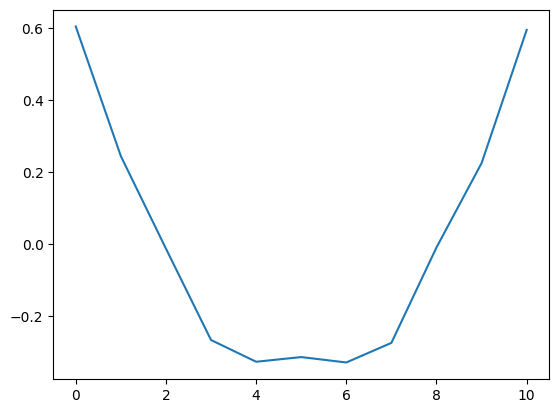

In [152]:
# Übersicht der Autokorrelation über 11 Monate
plt.plot(ac)

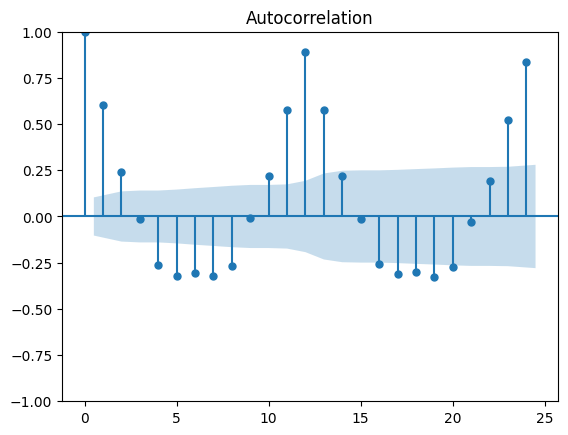

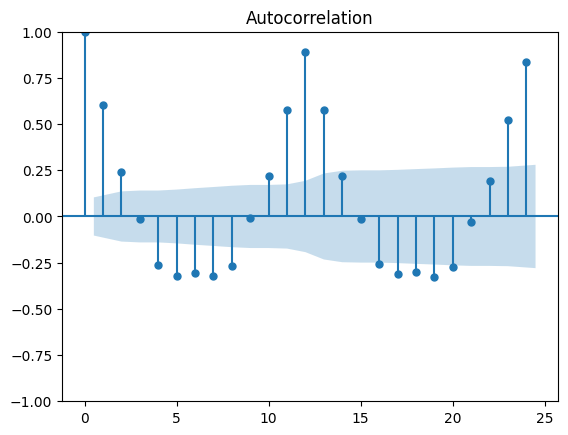

In [153]:
# Autokorrelation über zwei Jahre zum Vergleich
plot_acf(df_merged.Revenue.dropna(), lags=24)

## 5. Relation zu allen Wettermesswerten (Aufgabe 2c)

In [154]:
# Korrelationsmatrix aus allen Werten erstellen
df_merged.corr()
# Rundung auf zwei Nachkommastellen
corr = round(df_merged.corr(),2)
# Visualisierung mit Plotly
fig2 = px.imshow(corr,
                x=corr.columns,
                y=corr.columns,
                color_continuous_scale='Spectral',
                title='Correlation matrix',
                width=500,
                height=500)
fig2.show()

In [155]:
# Nur Korrelation mit Umsatz
corr = corr.Revenue
# Sortieren nach korrelationskoeffizienten Wert
revenue_corr = corr.sort_values(ascending=False)
revenue_corr

Revenue        1.00
 TXK           0.72
 TMK           0.70
 SDK           0.68
TMK_delayed    0.68
 TNK           0.67
 VPM           0.66
 TGK           0.64
Datum          0.25
Date           0.25
 RSK           0.12
  FX           0.04
  PM           0.00
SHK_TAG       -0.16
  FM          -0.25
RSKF          -0.34
  NM          -0.47
 UPM          -0.62
Name: Revenue, dtype: float64

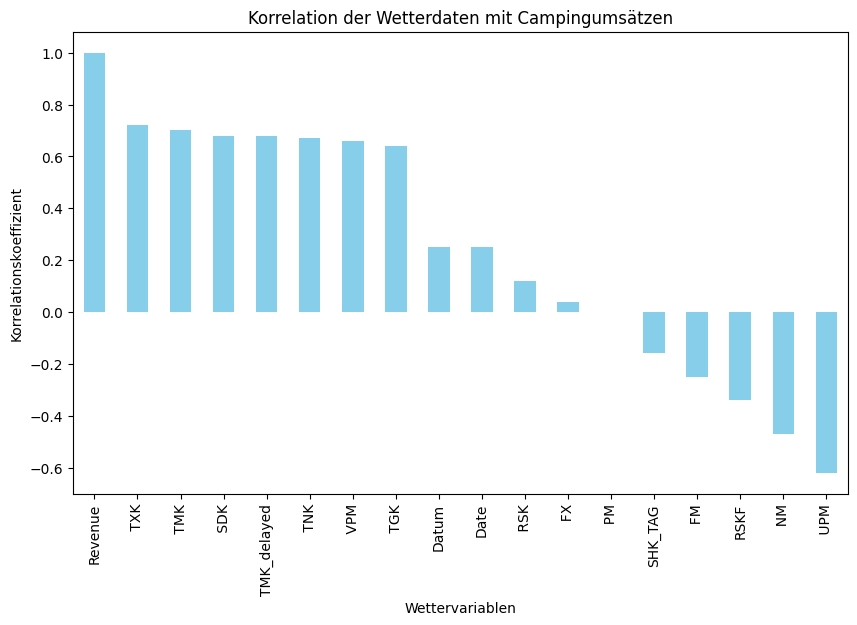

In [156]:
# Plot der sortierten Korrelationen
plt.figure(figsize=(10, 6))
revenue_corr.plot(kind='bar', color='skyblue')
plt.title('Korrelation der Wetterdaten mit Campingumsätzen')
plt.xlabel('Wettervariablen')
plt.ylabel('Korrelationskoeffizient')
plt.show()

## 6. Saison- und Trendbereinigung (Aufgabe 2d)

### 6.1 Trendbereinigung

In [157]:
# Trendbereinigung durch Signal
detrended = signal.detrend(df_merged['Revenue'].values)
df_merged['Revenue_detrended'] = detrended # hinzufügen neuer trendbereinigter Spalte

# Vergleich zwischen normalem Umsatz und Trendbereinigung, um die Veränderung zu veranschaulichen
fig_revenue = px.line(df_merged, x="Date", y=["Revenue","Revenue_detrended"], 
                      title="Vergleich Umsatzentwicklung von Campingplätzen als Liniendiagramm")
fig_revenue

In [158]:
# Scatter Darstellung mit R²-Linie
fig_revenue = px.scatter(df_merged, x="Date", y=["Revenue","Revenue_detrended"], 
                         trendline="ols", title="Vergleich Umsatzentwicklung von Campingplätzen mit OLS-Trendlinie")
fig_revenue.show()

### 6.2 Saisonbereinigung

In [159]:
# STL-Decomposition für Saisonbereinigung
stl = STL(df_merged['Revenue_detrended'], period=12)
# Anpassen der STL-Methode an die Daten
result = stl.fit()
# Berechnung der saisonbereinigten Umsätze
# Saisonbereinigte Umsätze = Trendbereinigte Umsätze - Saisonale Komponente
df_merged['Revenue_deseasonalized'] = df_merged['Revenue_detrended'] - result.seasonal
# Darstellung der Saisonalitätsbereinigung
fig_deseasonalized = px.line(df_merged, x="Date", y=["Revenue_deseasonalized"], title="Saison- und Trendbereinigte Umsatzentwicklung")
fig_deseasonalized

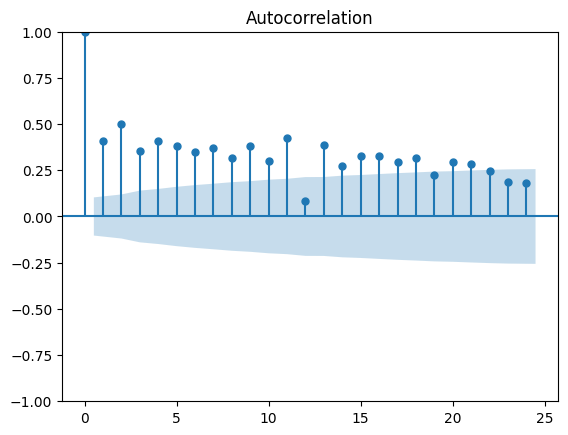

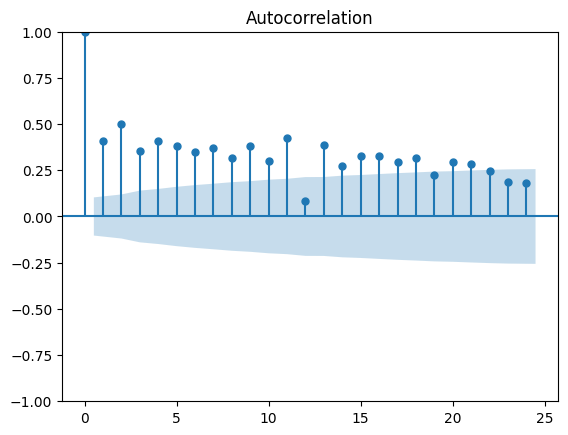

In [160]:
# Autokorrelation der Trend- und Saisonalitätsbereinigung
plot_acf(df_merged['Revenue_deseasonalized'], lags=24)

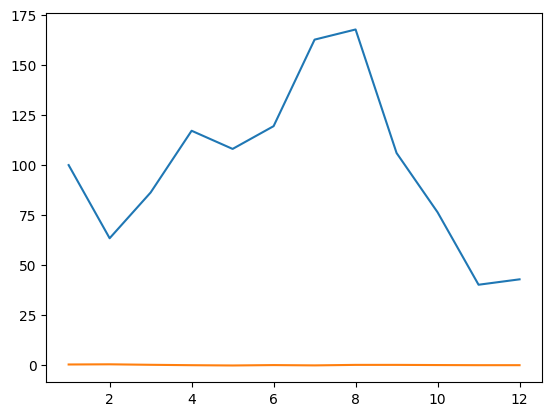

In [166]:
# Vergleich der Umsätze vor und nach Bereinigung

df_merged['month'] = df_merged['Datum'].dt.month

# Durchschnittliche monatliche Umsätze in den Originaldaten
seasonal_original = df_merged.groupby('month')['Revenue'].mean()

# Durchschnittliche monatliche Umsätze in den saisonbereinigten Daten
seasonal_deseasonalized = df_merged.groupby('month')['Revenue_deseasonalized'].mean()
plt.plot(seasonal_original)
plt.plot(seasonal_deseasonalized)

### 6.3 Relation zu Wetterdaten

In [167]:
# Spalten mit allen Wetterdaten auswählen
wetterdaten_filter = df_merged.columns.tolist()
wetterdaten_liste = wetterdaten_filter[2:16]

# Vorbereiten der Wetterdaten
X = df_merged[wetterdaten_liste]

# Regression für normale Umsätze
y_normal = df_merged['Revenue']
model_normal = LinearRegression()
model_normal.fit(X, y_normal)
y_pred_normal = model_normal.predict(X)
r2_normal = r2_score(y_normal, y_pred_normal)
print(f"R² für normale Umsätze: {r2_normal:.4f}")

# Regression für saisonbereinigte Umsätze
y_deseasonalized = df_merged['Revenue_deseasonalized']
model_deseasonalized = LinearRegression()
model_deseasonalized.fit(X, y_deseasonalized)
y_pred_deseasonalized = model_deseasonalized.predict(X)
r2_deseasonalized = r2_score(y_deseasonalized, y_pred_deseasonalized)
print(f"R² für saisonbereinigte Umsätze: {r2_deseasonalized:.4f}")


R² für normale Umsätze: 0.6502
R² für saisonbereinigte Umsätze: 0.1898
